In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm 

In [2]:
df = pd.read_csv('df_english.csv')

In [3]:
df.head(1)

,Id,Price,Address,Nearest_Subway,Publication_date,Num_of_rooms,Total_area,Living_space,Floor,Balcony,...,Cargo_lift,New_building_name,Building,Official_developer,Participation_type,Due_date,Link,Coordinates,WMO,Area
0,105724302,9800000,"Санкт-Петербург, Пушкинский р-н, пос. Шушары, ...",NaN,17.10.2022 в 10:16,3,73 м²,NaN,1 из 5,балкон,...,NaN,NaN,NaN,NaN,NaN,NaN,https://avito.ru//sankt-peterburg/kvartiry/3-k...,"59.737926, 30.461476",Шушары,Пушкинский


# Feature_engineering

### Обработка площади

In [4]:
# убираем м.кв. из "Total_area" и "Living_space"
def convert_area(value):
    correct_list = [str(i) for i in range(10)] + ['.']
    result = ''
    if pd.isna(value):
        return value
    for literal in str(value):
        if literal in correct_list:
            result += literal
    return result

for col in ["Total_area", "Living_space"]:
    df.loc[:, col] = df[col].apply(convert_area).astype(np.float32)

### Обработка целевого признака Price

Для начала прологорифмируем нашу целевую переменную и посмотрим даст ли нам это какие-либо результаты.

In [5]:
# для удобства создаем дубликат нашего датафрейма
df_dubl = df

<AxesSubplot:>

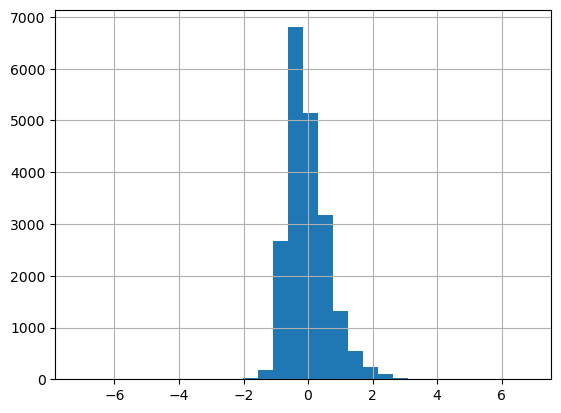

In [6]:
df_dubl['log_price'] = np.log(df_dubl['Price'])
df_dubl['log_price'] = df_dubl['log_price'] - df_dubl['log_price'].mean()
df_dubl.log_price.hist(bins=30)

In [7]:
import statsmodels.api as sm

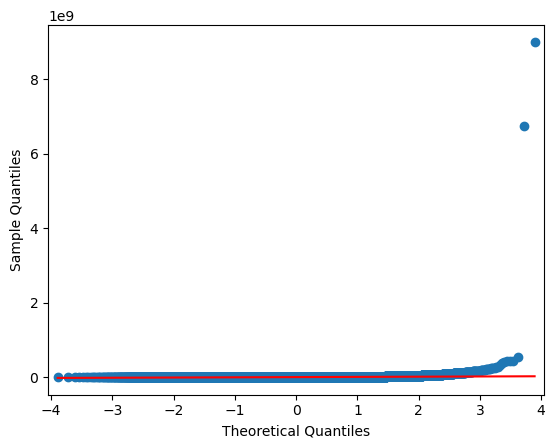

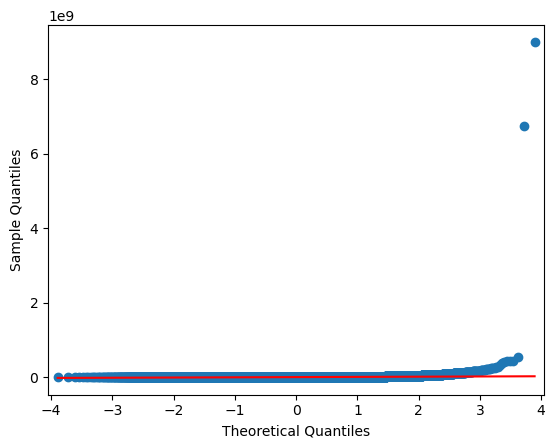

In [8]:
sm.qqplot(df_dubl['Price'], line='q')

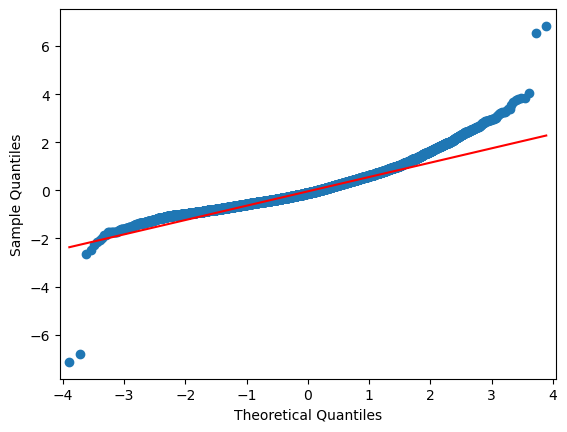

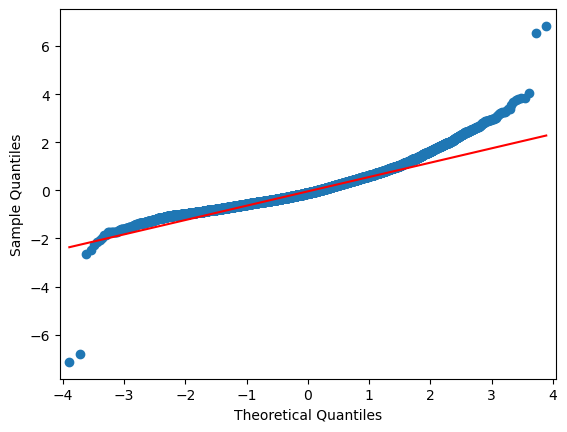

In [9]:

sm.qqplot(df_dubl['log_price'], line='q')

К сожалению, метод логарифмирования хоть приблизил распределение нашего трагета к более нормальному виду, но не решил нашу проблему. Помимо прочего у левого хвоста распределения также появились выбросы. Следовательно, этот метод нам не подойдет.

Попробуем ввести новую переменную основанную на вычеслении квадратных метров

In [10]:
# заполним пропуски нашего таргета 
df['Total_area'] = df['Total_area'].fillna(df['Total_area'].median())
# выполняем проверку на остаток пропусков
df['Total_area'].isnull().sum()

0

Вводим новый признак `Price_m_2`, который будет указывать на стоимость квадратного метра объекта недвижимости.

In [11]:
df['Price_m_2'] = df['Price'] / df['Total_area']

df['Price_m_2'].describe()

count    2.023500e+04
mean     2.397361e+05
std      2.092713e+06
min      1.297847e+02
25%      1.648752e+05
50%      1.993464e+05
75%      2.518850e+05
max      2.571429e+08
Name: Price_m_2, dtype: float64

Видим, что здесь так же присутсвуют выбросы. Для принятия окончательного решения (какую цену использовать) построим вместе графики цены в целом и цены за кв.м.

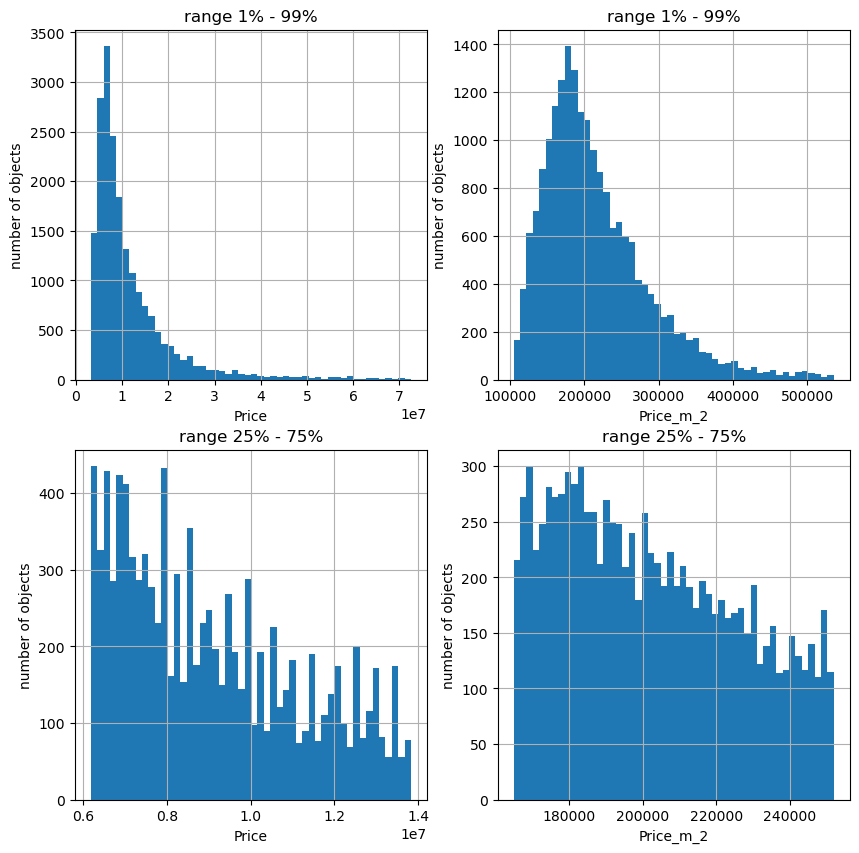

In [12]:
width = 2
height = 2
features = ['Price', 'Price_m_2']
low_perc = [1, 25]
high_perc = [99, 75]

_, axs = plt.subplots(width, height, figsize=(10, 10))
for j in range(width):
    for i in range(height):
        df[(df[features[i]] >= np.percentile(df[features[i]], low_perc[j])) & 
           (df[features[i]] <= np.percentile(df[features[i]], high_perc[j]))
           ][features[i]].hist(bins=50, ax=axs[j, i]) 
        axs[j, i].set_title(f'range {low_perc[j]}% - {high_perc[j]}%')
        axs[j, i].set_xlabel(features[i])
        axs[j, i].set_ylabel('number of objects')

plt.show()

Исключим из датафрейма объекты, выходящие из диапазона от 1 до 99 перцентиля по цене кв.м

In [13]:
df = df.drop(df[(df['Price_m_2'] < np.percentile(df['Price_m_2'], 1)) | 
                (df['Price_m_2'] > np.percentile(df['Price_m_2'], 99))].index)

Добавим категории цены квадратного метра. Это может повысить качество моделирования.

In [14]:
cost_categories = [0, 150e3, 200e3, 250e3, 300e3, float('inf')]

cost_categories_labels = [0, 1, 2, 3, 4]

df['Price_m_2_cat'] = pd.cut(df['Price_m_2'], cost_categories, labels=cost_categories_labels)

df.groupby(by='Price_m_2_cat')['Total_area'].agg({'count', 'mean'})

,mean,count
Price_m_2_cat,,
0,53.912937,3022
1,49.028728,7056
2,49.568359,4747
3,53.712578,2671
4,70.119629,2333


In [15]:
# # Избавимся от признаков, которые не несут информативности для нас.
# df = df.drop(['Id', 'Official_developer', 
#               'New_building_name', 'Building', 'Link', 'Floors_in_house'], axis=1)

# # Избавляем от признаков, у которых пропусков более 65%
# df = df.dropna(thresh=int(len(df) * .65), axis=1)

# # Избавляемся от дубликатов
# df = df.drop_duplicates(['Address', 'Total_area', 'Floor'])

После того как мы удалили все ненужные признаки, у нас остались следующие фичи:

In [16]:
df.columns

Index(['Id', 'Price', 'Address', 'Nearest_Subway', 'Publication_date',
       'Num_of_rooms', 'Total_area', 'Living_space', 'Floor', 'Balcony',
       'Room_type', 'Ceiling_height', 'Bathroom', 'Windows', 'Repair',
       'Furniture', 'Warm_floor', 'Decoration', 'Appliances', 'Sale_method',
       'Deal_type', 'House_type', 'Year_build', 'Floors_in_house',
       'Passenger_lift', 'Parking', 'In_house', 'Yard', 'Cargo_lift',
       'New_building_name', 'Building', 'Official_developer',
       'Participation_type', 'Due_date', 'Link', 'Coordinates', 'WMO', 'Area',
       'log_price', 'Price_m_2', 'Price_m_2_cat'],
      dtype='object')

С ними мы и будем работать.

### Обработка координат

Ориентироваться на адрес не очень удобно, поэтому этот признак преобразуем в кооридинаты

In [17]:
df[['lat_object', 'lon_object']] = df['Coordinates'].str.split(', ',expand=True).astype('float')

df[['lat_object', 'lon_object']].describe()

,lat_object,lon_object
count,19829.000000,19829.000000
mean,59.667805,30.482854
std,2.076877,3.252004
min,38.552623,-4.719892
25%,59.852673,30.250363
50%,59.931012,30.326360
75%,60.000654,30.406787
max,60.262019,137.986851


Видно, что в данных есть выбросы, не характерные для координат СПб. Ограничив последние диапазоном по широте от 58,7 до 61 град и по долготе от 28,5 до 33,5, введем фильтр.

In [18]:
df[(df['lat_object'] > 61) | (df['lat_object'] < 58.7) | 
   (df['lon_object'] > 33.5) | (df['lon_object'] < 28.5)]['Price'].count()

360

In [19]:
df = df.drop(df[(df['lat_object'] > 61) | (df['lat_object'] < 58.7) | 
   (df['lon_object'] > 33.5) | (df['lon_object'] < 28.5)].index)

In [20]:
#удаляем лишний столбец 
df = df.drop(["Coordinates"], axis=1)
# может еще понадобится удалить столбец Address

С КООРДИНАТАМИ НУЖНО ЕЩЕ ЗАМОРОЧИТЬСЯ И ИЗМЕРИТЬ РАССТОЯНИЕ ДО ЦЕНТРА!!!

### Обработка "Floor"

In [21]:
# разделим общее количество этажей в доме
# и квариру на конкретном этаже.
new_df = df['Floor'].str.split('из',expand=True)

#переименуем наши фичи
new_df.columns=['Flat_floor','Total_floor']

# объединим два датафрейма
df = pd.concat([df,new_df],axis=1)

# удалим ненужную фичу
df = df.drop(['Floor'], axis=1)

### Обработка Num_of_rooms

In [22]:
df.loc[df['Num_of_rooms'] == 'студия', ['Num_of_rooms']] = 0
df.loc[df['Num_of_rooms'] == '10 и больше', ['Num_of_rooms']] = 10
df = df.loc[df['Num_of_rooms'] != 'свободная планировка']

In [23]:
df['Num_of_rooms'].unique()

array(['3', '2', '1', 0, '4', '5', '7', '6', nan, 10, '8', '9'],
      dtype=object)

### Дополнительный Dataframe с координатами метро

Также нам понадобится еще один DataFrame с использованием координат местонахождения станций метро. Координаты в процессе работы также были нами спаршены.

In [24]:
path = 'C:/Users/Nekon/PetProject-price-real-estate-in-St.-Petersburg/parser/metro.csv'
subway_coordinates = pd.read_csv(path)
subway_coordinates.head()

,Станция,Координаты
0,Девяткино,"60.050182, 30.443045"
1,Гражданский проспект,"60.034969, 30.418224"
2,Академическая,"60.012806, 30.396044"
3,Политехническая,"60.008942, 30.370907"
4,Площадь Мужества,"59.999828, 30.366159"


In [25]:
#переименовываем название наших фичей
new_names = [
    "Station", "Coordinates"
 ]
mapper = {key:value for key, value in zip(subway_coordinates.columns.values, new_names)}

subway_coordinates.rename(columns=mapper, inplace=True)

In [26]:
#разделяем коррдинаты станций метро по широте и долготе
subway_coordinates[['lat_subway', 'lon_subway']] = subway_coordinates['Coordinates'].str.split(', ',expand=True).astype('float')

#переводим название станций метро в нижний регистр
subway_coordinates['Station'] = subway_coordinates['Station'].str.lower()

#удаляем уже ненужную фичу 'Station'
subway_coordinates = subway_coordinates.drop('Coordinates', axis=1)

subway_coordinates.head(1)

,Station,lat_subway,lon_subway
0,девяткино,60.050182,30.443045


Следующим шагом создадим функцию для расчета расстояния объекта до каждого метро

In [27]:
def destinator(latitiude_init, longitude_init, latitiude_fin, longitude_fin):
    '''
    Расчет расстояния в км
    '''
    return round(np.sqrt((latitiude_init - latitiude_fin)**2 + 
                        (longitude_init - longitude_fin)**2) * 111.13, 3)

def subway_distance_calculator(row, latitiude_fin, longitude_fin):
#    latitiude_init = row['Широта_Объекта']
#    longitude_init = row['Долгота_Объекта']
#
#    metro_distances = {}
#
#    for i in range(len(metro_coordinates)):
#        latitiude_fin = metro_coordinates['Широта'][i]
#        longitude_fin = metro_coordinates['Долгота'][i]
#
#        metro_distances[metro_coordinates['Станция'][i]] = [destinator(latitiude_init, longitude_init, latitiude_fin, longitude_fin)]
        

    return destinator(row['lat_object'], row['lon_object'], latitiude_fin, longitude_fin)

In [28]:
# Для корректной работы функции требуется сбросить индексы
df = df.reset_index(drop=True)

In [29]:
stations = ['расстояние_до_' + "_".join(x.split()) for x in subway_coordinates['Station']]
for i in tqdm(range(len(stations))):
    df[stations[i]] = df.apply(subway_distance_calculator, 
                               args=(subway_coordinates['lat_subway'][i], 
                                     subway_coordinates['lon_subway'][i]), 
                               axis=1
                              )

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:41<00:00,  1.75it/s]


In [30]:
df.head(1)

,Id,Price,Address,Nearest_Subway,Publication_date,Num_of_rooms,Total_area,Living_space,Balcony,Room_type,...,расстояние_до_адмиралтейская,расстояние_до_садовая,расстояние_до_звенигородская,расстояние_до_обводный_канал,расстояние_до_волковская,расстояние_до_бухарестская,расстояние_до_международная,расстояние_до_дунайская,расстояние_до_проспект_славы,расстояние_до_шушары
0,105724302,9800000,"Санкт-Петербург, Пушкинский р-н, пос. Шушары, ...",NaN,17.10.2022 в 10:16,3,73.0,NaN,балкон,изолированные,...,27.35,26.37,25.042,23.334,21.026,19.195,17.306,12.66,15.105,9.662


### Обработка WOE

Построим карту объявлений с цветовой подсветкой по районам и измением размера точки от цены кв.м

In [31]:
def map_objects(feature, hue, df=df):
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=df, 
                    x='lat_object', 
                    y='lon_object', 
                    hue=hue, 
                    size=feature,
                    sizes=(10,200))

    sns.scatterplot(data=df[df[feature] == df[feature].max()], 
                    x='lat_object', 
                    y='lon_object', 
                    marker='*', 
                    s=200, 
                    color='r',
                    palette='flag',
                    label=f'Макс {feature}')
    sns.scatterplot(data=df[df[feature] == df[feature].min()], 
                    x='lat_object', 
                    y='lon_object', 
                    marker='*', 
                    s=200, 
                    color='g',
                    palette='flag',
                    label=f'Мин {feature}')
    plt.show()

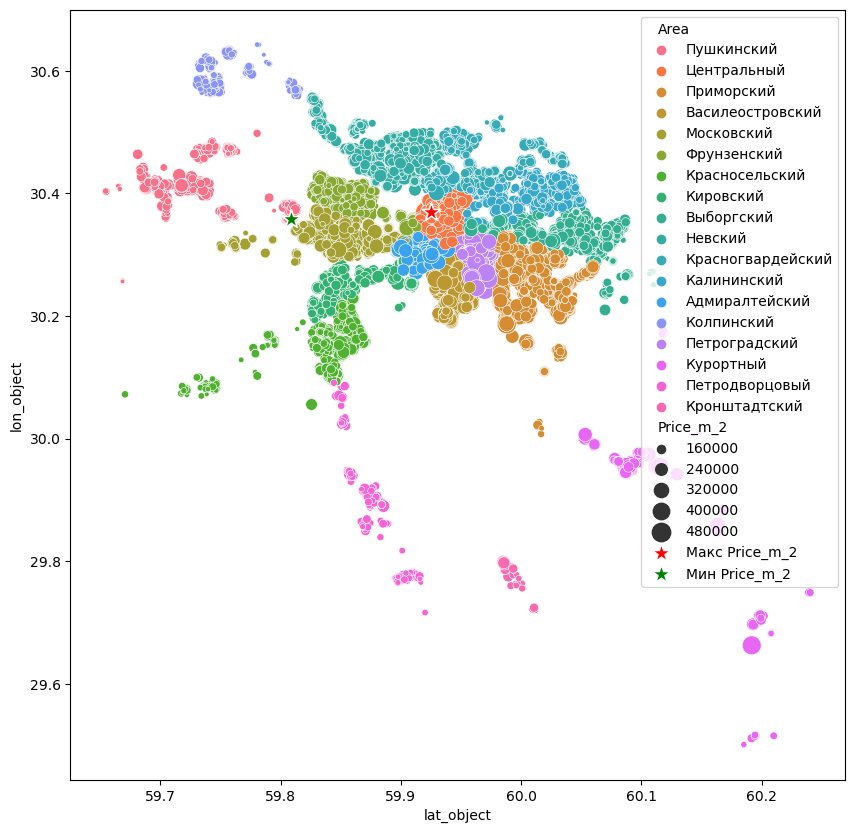

In [32]:
map_objects('Price_m_2', 'Area')

Построим еще сводную таблицу по средней стоимости квадратного метра в каждом районе.

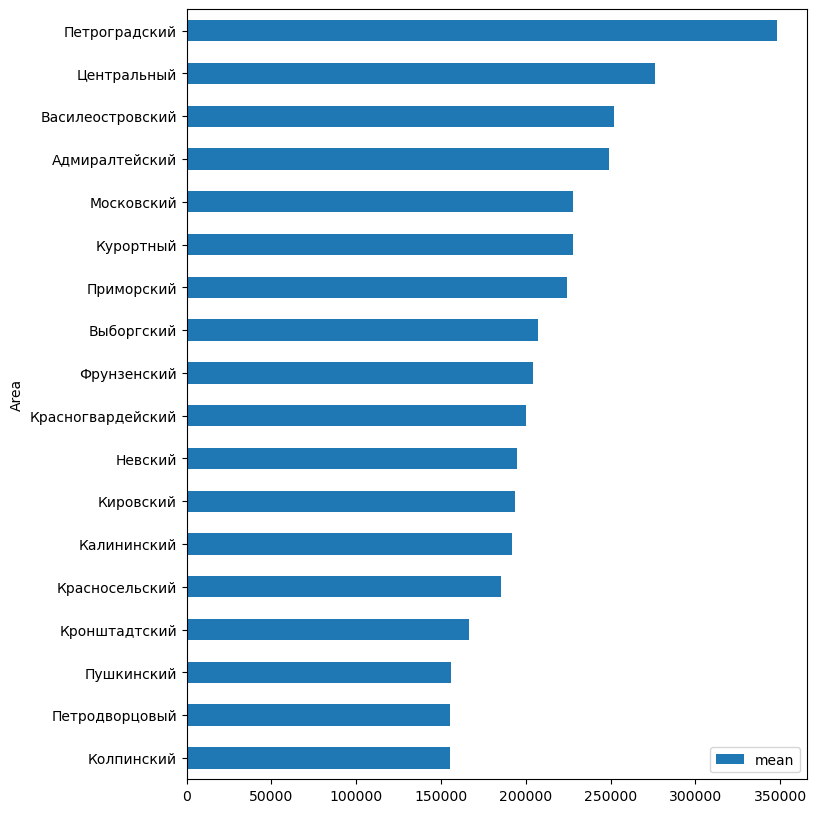

In [33]:
total = df.groupby(by='Area')['Price_m_2'].agg({'mean'}).sort_values(by='mean').plot(figsize=(8,10), kind="barh")
plt.show(total)

In [34]:
#создадим обрезанный датафрейм, чтобы было более наглядно видно средние значения цены.
cut_df = df.groupby(by='Area')['Price_m_2'].agg({'mean'}).sort_values(by='mean')
cut_df.reset_index(inplace= True)
cut_df

,Area,mean
0,Колпинский,155148.545361
1,Петродворцовый,155467.145332
2,Пушкинский,156105.652683
3,Кронштадтский,166384.859419
4,Красносельский,185114.145101
5,Калининский,191993.529735
6,Кировский,193828.917083
7,Невский,195010.400534
8,Красногвардейский,200351.040573
9,Фрунзенский,204314.416765


In [35]:
#сгруппируем наши районы по средней стоимости за квадратный метр
group_1 = cut_df[cut_df['mean'] < 200000]
group_2 = cut_df[(cut_df['mean'] > 200000) & (cut_df['mean'] < 250000)]
group_3 = cut_df[(cut_df['mean'] > 250000) & (cut_df['mean'] < 300000)]
group_ =cut_df[cut_df['mean'] > 300000]

In [36]:
group_3

,Area,mean
15,Василеостровский,252139.806640
16,Центральный,276295.506693


In [37]:
df['Group_area'] = df['Area']

Теперь в основном датафрейме, закодируем наши районны, согласно выбранные группам.

In [38]:
#присваем номер группы, каждому из районов
cleanup_area = {"Group_area":     {
    "Колпинский": 1, "Петродворцовый": 1, "Пушкинский": 1, "Кронштадтский": 1,
    "Красносельский": 1, "Калининский": 1, "Кировский": 1, "Невский": 1, 
    "Красногвардейский": 1, "Фрунзенский": 1, "Выборгский": 1, "Приморский": 1, 
    "Курортный": 1, "Московский": 1, "Адмиралтейский": 1, 
    "Василеостровский": 2, "Центральный": 2, "Петроградский": 2 
                  }}

In [39]:
# df = df.replace(cleanup_area)

In [40]:
# переводим получившиеся значения из float в int
df = df.replace(cleanup_area).astype({"Group_area": "Int64"})

In [41]:
# переименуем наши фичи на 'name' и 'group'
df.rename(columns = {'Area':'name', 'Group_area':'group'}, inplace = True )

In [42]:
bounds = df[['name','group']]

In [43]:
bounds

,name,group
0,Пушкинский,1
1,Центральный,2
2,Приморский,1
3,Василеостровский,2
4,Московский,1
...,...,...
19436,Выборгский,1
19437,Кировский,1
19438,Невский,1
19439,Адмиралтейский,1


In [44]:
x = df['name']
y = df['Price']

In [45]:
def WOE_transform_QL(x, y, bounds):
    
    t0 = np.zeros(x.size)   
    #print('Size:',x.size)

    for i in range(0,x.size):
        
        a = 0;

        for j in range(0, pd.DataFrame(bounds['group']).size):   
            
            if x[i] == np.nan:
                t0[i] = -1.0
                break;
            
            if x[i] == bounds['name'].values[j]:
                t0[i] = bounds['group'].values[j]  
                a=1
                break;  

        if a == 0 & (not (x[i]==np.nan)):
            t0[i] = bounds['group'].max() + 1 ;
            
    t1 = pd.DataFrame({
        
        'value' : x,
        'group' : t0,
        'target': y
    })
    
    tot_bads = sum(t1.target)    
    tot_goods = t1.target.size - tot_bads
    
    count_part = t1.groupby(['group']).agg({'group' : 'count'}).rename(columns={'group' : 'count'}).reset_index()
    
    bads_part = t1.groupby('group')['target'].sum()/tot_bads
    goods_part = (t1.groupby('group')['target'].size() - t1.groupby('group')['target'].sum())/(tot_goods)
    
    WoE = np.log(goods_part/ bads_part)     
    
    goods_part = goods_part.reset_index()    
    goods_part.columns = ['group','G_pc']
    
    indx_extr = goods_part['G_pc'] == 0.0
    
    WoE = WoE.reset_index()
    WoE.columns = ['group','WoE']
    
    WoE = pd.merge(WoE, count_part, how='inner',on='group')    
    WoE.loc[indx_extr,'WoE'] = -9.99 
    WoE.columns = ['group','WoE','count']

    print(WoE)
    print('-------------------------\n')                
    
    t_fin = t1[['value','group']]
    
    T = t_fin.merge(WoE[['group','WoE']], left_on = 'group',right_on = 'group', how='left')    
    T = T.drop(['value','group'], axis=1)
    
#     print(T)
    
    T1 = [T, WoE]
    
    return T1

In [46]:
Total = WOE_transform_QL(x, y, bounds)

   group           WoE  count
0    1.0 -1.258024e-08  15768
1    2.0  3.850200e-08   2618
2    3.0 -1.403447e-08   1055
-------------------------



In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19441 entries, 0 to 19440
Columns: 116 entries, Id to group
dtypes: Int64(1), category(1), float32(2), float64(78), int64(2), object(32)
memory usage: 16.9+ MB


### Обработка Nearest_Subway

Для начала разделим на 4 столца информацию о ближайших станциях метро

In [48]:
subway_stations = df['Nearest_Subway'].str.split(' мин.',expand=True)
subway_stations = subway_stations.fillna('no_info')
subway_stations.columns = ['subway_stations_1', 'subway_stations_2', 'subway_stations_3', 'subway_stations_4']
subway_stations

,subway_stations_1,subway_stations_2,subway_stations_3,subway_stations_4
0,no_info,no_info,no_info,no_info
1,Гостиный двор11–15,Невский проспект11–15,Маяковская11–15,
2,Комендантский проспект6–10,Старая деревняот 31,Пионерскаяот 31,
3,Приморскаяот 31,Василеостровскаяот 31,,no_info
4,Звёздная6–10,Купчино21–30,Московская21–30,
...,...,...,...,...
19436,Проспект Просвещенияот 31,Озеркиот 31,Гражданский проспектот 31,
19437,р-н Красносельский,no_info,no_info,no_info
19438,Пролетарская16–20,Обухово21–30,Ломоносовскаяот 31,
19439,Балтийская21–30,Московские ворота21–30,Фрунзенская21–30,


На первый взгляд видно, что в metro_station_4 есть только отсутствующие значения, проверим нашу гипотезу.

In [49]:
subway_stations['subway_stations_4'].unique()

array(['no_info', ''], dtype=object)

Предположения подтвердились. В таком случае, удаляем этот столбец.

In [50]:
subway_stations = subway_stations.drop('subway_stations_4', axis=1)

Отделим время до метро от названия станций.

In [51]:
def find_pattern(string: str, pattern: str):
    if re.search(pattern, string):
        return re.search(pattern, string).group(0)

def del_pattern(string: str, pattern: str):
    if re.search(pattern, string):
        return string.replace(pattern, "")
    else:
        return string

In [52]:
pattern_station_name = '^\D*'
pattern_duration = '\d\d$'
pattern_ot = 'от '
pattern_do = 'до '

In [53]:
subway_stations['subway_stations_1_duration'] = subway_stations['subway_stations_1'].apply(lambda x: find_pattern(x, pattern_duration))
subway_stations['subway_stations_2_duration'] = subway_stations['subway_stations_2'].apply(lambda x: find_pattern(x, pattern_duration))
subway_stations['subway_stations_3_duration'] = subway_stations['subway_stations_3'].apply(lambda x: find_pattern(x, pattern_duration))

subway_stations['subway_stations_1'] = subway_stations['subway_stations_1'].apply(lambda x: find_pattern(x, pattern_station_name))
subway_stations['subway_stations_2'] = subway_stations['subway_stations_2'].apply(lambda x: find_pattern(x, pattern_station_name))
subway_stations['subway_stations_3'] = subway_stations['subway_stations_3'].apply(lambda x: find_pattern(x, pattern_station_name))

subway_stations['subway_stations_1'] = subway_stations['subway_stations_1'].apply(lambda x: del_pattern(x, pattern_ot))
subway_stations['subway_stations_2'] = subway_stations['subway_stations_2'].apply(lambda x: del_pattern(x, pattern_ot))
subway_stations['subway_stations_3'] = subway_stations['subway_stations_3'].apply(lambda x: del_pattern(x, pattern_ot))

subway_stations['subway_stations_1'] = subway_stations['subway_stations_1'].apply(lambda x: del_pattern(x, pattern_do))
subway_stations['subway_stations_2'] = subway_stations['subway_stations_2'].apply(lambda x: del_pattern(x, pattern_do))
subway_stations['subway_stations_3'] = subway_stations['subway_stations_3'].apply(lambda x: del_pattern(x, pattern_do))

subway_stations = subway_stations.fillna('no_info')

In [54]:
subway_stations.head()

,subway_stations_1,subway_stations_2,subway_stations_3,subway_stations_1_duration,subway_stations_2_duration,subway_stations_3_duration
0,no_info,no_info,no_info,no_info,no_info,no_info
1,Гостиный двор,Невский проспект,Маяковская,15,15,15
2,Комендантский проспект,Старая деревня,Пионерская,10,31,31
3,Приморская,Василеостровская,,31,31,no_info
4,Звёздная,Купчино,Московская,10,30,30


In [55]:
subway_stations['subway_stations_1_duration'].unique()

array(['no_info', '15', '10', '31', '20', '30'], dtype=object)

In [56]:
# посмотрим какие названия станций у нас есть.
sorted(subway_stations['subway_stations_1'].unique().tolist())

['no_info',
 'Автово',
 'Адмиралтейская',
 'Академическая',
 'Балтийская',
 'Беговая',
 'Бухарестская',
 'Василеостровская',
 'Владимирская',
 'Волковская',
 'Выборгская',
 'Горьковская',
 'Гостиный двор',
 'Гражданский проспект',
 'Девяткино',
 'Достоевская',
 'Дунайская',
 'Елизаровская',
 'Звенигородская',
 'Звёздная',
 'Кировский завод',
 'Комендантский проспект',
 'Крестовский остров',
 'Купчино',
 'Ладожская',
 'Ленинский проспект',
 'Лесная',
 'Лиговский проспект',
 'Ломоносовская',
 'Маяковская',
 'Международная',
 'Московская',
 'Московские ворота',
 'Нарвская',
 'Невский проспект',
 'Новокрестовская',
 'Новочеркасская',
 'Обводный канал',
 'Обухово',
 'Озерки',
 'Парк Победы',
 'Парнас',
 'Петроградская',
 'Пионерская',
 'Площадь А. Невского I',
 'Площадь А. Невского II',
 'Площадь Восстания',
 'Площадь Ленина',
 'Площадь Мужества',
 'Политехническая',
 'Приморская',
 'Пролетарская',
 'Проспект Большевиков',
 'Проспект Ветеранов',
 'Проспект Просвещения',
 'Проспект Славы',
 

Переименуем названия в соответствии с их названиями в файле с координатами, а ткже названия райнов заменим на no_info

In [57]:
rename = {
    'Новокрестовская': 'Зенит',
    'Площадь А. Невского I': 'Площадь Александра Невского 1',
    'Площадь А. Невского II': 'Площадь Александра Невского 2',
    'Технологический ин-т I': 'Технологический институт',
    'Технологический ин-т II': 'Технологический институт 2',
    'р-н Калининский': 'no_info',
    'р-н Красногвардейский': 'no_info',
    'р-н Красносельский': 'no_info',
    'р-н Московский': 'no_info',
    'р-н Приморский': 'no_info',
    '': 'no_info',
}

In [58]:
subway_stations = subway_stations.replace(rename)

Теперь сохраним в датафрейм только столбцы с названиями станций и минимальным временем до метро (если время одинаковое для нескольких станций метро, будем указывать только одно ближайшее).

In [59]:
df[['Subway_station', 'Time_for_subway']] = subway_stations[['subway_stations_1', 'subway_stations_1_duration']]

In [60]:
df.head(5)

,Id,Price,Address,Nearest_Subway,Publication_date,Num_of_rooms,Total_area,Living_space,Balcony,Room_type,...,расстояние_до_обводный_канал,расстояние_до_волковская,расстояние_до_бухарестская,расстояние_до_международная,расстояние_до_дунайская,расстояние_до_проспект_славы,расстояние_до_шушары,group,Subway_station,Time_for_subway
0,105724302,9800000,"Санкт-Петербург, Пушкинский р-н, пос. Шушары, ...",NaN,17.10.2022 в 10:16,3,73.0,NaN,балкон,изолированные,...,23.334,21.026,19.195,17.306,12.660,15.105,9.662,1,no_info,no_info
1,110963888,24000000,"Санкт-Петербург, наб. реки Фонтанки, 28",Гостиный двор11–15 мин.Невский проспект11–15 м...,17.10.2022 в 01:22,3,85.0,NaN,NaN,изолированные,...,2.767,5.043,6.779,8.641,13.331,10.838,16.558,2,Гостиный двор,15
2,128257189,12500000,"Санкт-Петербург, Камышовая ул., 3к1",Комендантский проспект6–10 мин.Старая деревняо...,22.10.2022 в 10:29,2,55.0,NaN,лоджия,изолированные,...,14.534,16.742,18.602,20.489,25.331,22.808,28.624,1,Комендантский проспект,10
3,139963851,14200000,"Санкт-Петербург, ул. Беринга, 1",Приморскаяот 31 мин.Василеостровскаяот 31 мин.,21.10.2022 в 16:53,1,50.0,32.0,балкон,NaN,...,11.257,12.839,14.521,16.203,20.883,18.485,24.129,2,Приморская,31
4,204005328,5500000,"Санкт-Петербург, Пулковская ул., 8к2",Звёздная6–10 мин.Купчино21–30 мин.Московская21...,16.10.2022 в 03:52,0,26.0,14.0,балкон,NaN,...,8.531,6.473,5.414,4.676,6.504,5.234,9.174,1,Звёздная,10


Сохраним наш получившийся DataFrame для дальнейшей работы в 'df_engineering.csv'.

In [61]:
df.to_csv('df_engineering.csv', index=False)